In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from PIL import Image
import os
import shutil

In [2]:
class Discriminator(nn.Module):
    def __init__(self, channels_img, features_d):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            nn.Conv2d(channels_img, features_d, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            self._block(features_d, features_d*2, 4, 2, 1),
            self._block(features_d*2, features_d*4, 4, 2, 1),
            self._block(features_d*4, features_d*8, 4, 2, 1),
            nn.Conv2d(features_d*8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )
    
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.disc(x)

In [3]:
class Generator(nn.Module):
    def __init__(self, z_dim, channels_img, features_g):
        super(Generator, self).__init__()
        self.gen = nn.Sequential (
            self._block(z_dim, features_g*16, 4, 1, 0),
            self._block(features_g*16, features_g*8, 4, 2, 1),
            self._block(features_g*8, features_g*4, 4, 2, 1),
            self._block(features_g*4, features_g*2, 4, 2, 1),
            nn.ConvTranspose2d(features_g*2, channels_img, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )
    
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.gen(x)


In [4]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [5]:
def test():
    N, in_channels, H, W = 8, 3, 64, 64
    z_dim = 100
    x = torch.randn((N, in_channels, H, W))
    disc = Discriminator(in_channels, 8)
    initialize_weights(disc)
    assert disc(x).shape == (N, 1, 1, 1)
    gen = Generator(z_dim, in_channels, 8)
    initialize_weights(gen)
    z = torch.randn((N, z_dim, 1, 1))
    assert gen(z).shape == (N, in_channels, H, W)
    print("Success")

In [6]:
test()

Success


In [7]:
LEARNING_RATE = 3e-4
BATCH_SIZE = 128
IMAGE_SIZE = 64
CHANNELS_IMG = 3
Z_DIM = 100
NUM_EPOCHS = 100
FEATURES_DISC = 64
FEATURES_GEN = 64

In [8]:
jpgcnt = 0
pngcnt = 0
for image in os.listdir('datasets/pokemon/images'):
    ext = os.path.splitext(image)[1]
    if ext == '.jpg':
        jpgcnt += 1
    elif ext == '.png':
        pngcnt += 1
print(f'Number of .jpg: {jpgcnt}')
print(f'Number of .png: {pngcnt}')


Number of .jpg: 88
Number of .png: 721


In [9]:
for image in os.listdir('datasets/pokemon-pngs/images'):
    path = 'datasets/pokemon-pngs/images/'+os.path.splitext(image)[0]+os.path.splitext(image)[1]
    os.remove(path)

In [10]:
for image in os.listdir('datasets/pokemon/images'):
    ext = os.path.splitext(image)[1]
    oldpath = 'datasets/pokemon/images/'+os.path.splitext(image)[0]+os.path.splitext(image)[1]
    newpath = 'datasets/pokemon-pngs/images/'+os.path.splitext(image)[0]+os.path.splitext(image)[1]
    newpath2 = 'datasets/pokemon-jpgs/images/'+os.path.splitext(image)[0]+os.path.splitext(image)[1]
    if ext == '.png':
        shutil.copyfile(oldpath, newpath)
    elif ext == '.jpg':
        shutil.copyfile(oldpath, newpath2)


In [11]:
for image in os.listdir('datasets/pokemon/images'):
    ext = os.path.splitext(image)[1]
    path = 'datasets/pokemon/images/'+os.path.splitext(image)[0]+os.path.splitext(image)[1]
    
    if ext == '.png':
        new_filename = os.path.splitext(image)[0]+'.png'
        img = Image.open(path)
        img.convert('RGBA')
        img.save('datasets/pokemon-pngs/images/'+new_filename)
        
    elif ext == '.jpg':
        new_filename = os.path.splitext(image)[0]+'.jpg'
        img = Image.open(path)
        img.convert('RGBA')
        img.save('datasets/pokemon-jpgs/images/'+new_filename)
        
    new_filename = os.path.splitext(image)[0]+'.png'
    img = Image.open(path)
    img.convert('RGBA')
    img.save('datasets/pokemon-convertedRGBA/images/'+new_filename)

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

/home/ec2-user/anaconda3/envs/pytorch_p38/lib/python3.8/site-packages/PIL/Image.py:945: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


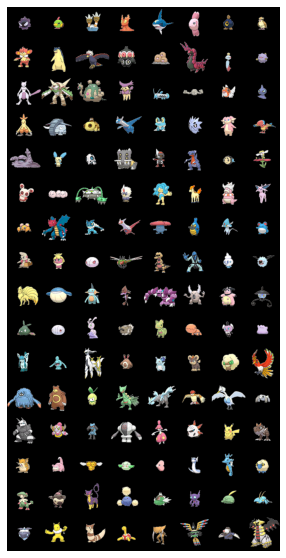

In [13]:
pokemon_raw = torchvision.datasets.ImageFolder(root="datasets/pokemon-pngs", transform=transform)
data_loader = DataLoader(dataset=pokemon_raw, batch_size=BATCH_SIZE, shuffle=True)

images, _ = iter(data_loader).next()
img = torchvision.utils.make_grid(images)

img = img.detach().cpu().numpy()
img = img.clip(0,1)

plt.figure(figsize = (12, 10))
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.axis('off')
plt.show()

In [14]:
data_mean = []
data_std = []

for i, data in enumerate(data_loader, 0):
    
    numpy_image = data[0].numpy()
    
    batch_mean = np.mean(numpy_image, axis=(0, 2, 3))
    batch_std = np.std(numpy_image, axis=(0, 2, 3))
    
    data_mean.append(batch_mean)
    data_std.append(batch_std)
    
data_mean = np.array(data_mean)
data_std = np.array(data_std)

data_mean = data_mean.mean(axis=0)
data_std = data_std.mean(axis=0)

In [15]:
print(data_mean, data_std)

[0.09862038 0.09457188 0.0880022 ] [0.25315762 0.24089463 0.2297551 ]


In [16]:
transform = transforms.Compose(
    [
        transforms.Resize(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]),
    ]
)

pokemon = torchvision.datasets.ImageFolder(root="datasets/pokemon-pngs", transform=transform)

data_loader = DataLoader(dataset=pokemon, batch_size=BATCH_SIZE, shuffle=True)

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [18]:
gen = Generator(Z_DIM, CHANNELS_IMG, FEATURES_GEN).to(device)
disc = Discriminator(CHANNELS_IMG, FEATURES_DISC).to(device)
initialize_weights(gen)
initialize_weights(disc)

opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
criterion = nn.BCELoss()

In [19]:
gen.train()
disc.train()

fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)

img_grid_reals = []
img_grid_fakes = []
gen_losses = []
disc_losses = []

In [20]:
for epoch in range(1, NUM_EPOCHS+1):
    # Target labels not needed! <3 unsupervised
    for batch_idx, (real, _) in enumerate(data_loader):
        real = real.to(device)
        noise = torch.randn((BATCH_SIZE, Z_DIM, 1, 1)).to(device)
        fake = gen(noise)

        ### Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        disc_real = disc(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc.zero_grad()
        loss_disc.backward()
        opt_disc.step()

        ### Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))
        output = disc(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        if batch_idx % 1 == 0:
            with torch.no_grad():
                fake = gen(fixed_noise)
                # take out (up to) 32 examples
                img_grid_real = torchvision.utils.make_grid(
                    real[:32], normalize=True
                )
                img_grid_fake = torchvision.utils.make_grid(
                    fake[:32], normalize=True
                )
            
    if epoch % 1 == 0:
        print(
            f"Epoch [{epoch}/{NUM_EPOCHS}] \
            Loss D: {loss_disc:.4f}, Loss G: {loss_gen:.4f}"
        )
    if epoch % 100 == 0 or epoch == 0:
        img_grid_reals.append(img_grid_real)
        img_grid_fakes.append(img_grid_fake)
    
    gen_losses.append(loss_gen)
    disc_losses.append(loss_disc)

Epoch [1/100]             Loss D: 0.3761, Loss G: 1.2473
Epoch [2/100]             Loss D: 0.2113, Loss G: 1.6697
Epoch [3/100]             Loss D: 0.1342, Loss G: 2.0513
Epoch [4/100]             Loss D: 0.0914, Loss G: 2.3875
Epoch [5/100]             Loss D: 0.0636, Loss G: 2.7105
Epoch [6/100]             Loss D: 0.0479, Loss G: 3.0027
Epoch [7/100]             Loss D: 0.0379, Loss G: 3.2305
Epoch [8/100]             Loss D: 0.0286, Loss G: 3.4588
Epoch [9/100]             Loss D: 0.0239, Loss G: 3.6595
Epoch [10/100]             Loss D: 0.0315, Loss G: 2.8980
Epoch [11/100]             Loss D: 0.0178, Loss G: 4.0105
Epoch [12/100]             Loss D: 0.0136, Loss G: 4.2518
Epoch [13/100]             Loss D: 0.0122, Loss G: 4.3809
Epoch [14/100]             Loss D: 0.0108, Loss G: 4.5249
Epoch [15/100]             Loss D: 0.0096, Loss G: 4.6421
Epoch [16/100]             Loss D: 0.0077, Loss G: 4.7680
Epoch [17/100]             Loss D: 0.0074, Loss G: 4.8407
Epoch [18/100]         

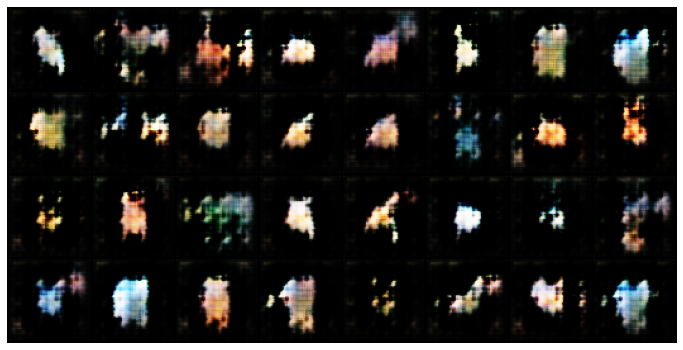

In [21]:
img = img_grid_fakes[-1]

img = img.detach().cpu().numpy()
img = img.clip(0,1)

plt.figure(figsize = (12, 10))
plt.imshow(np.transpose(img, (1, 2, 0)))
plt.axis('off')
plt.show()

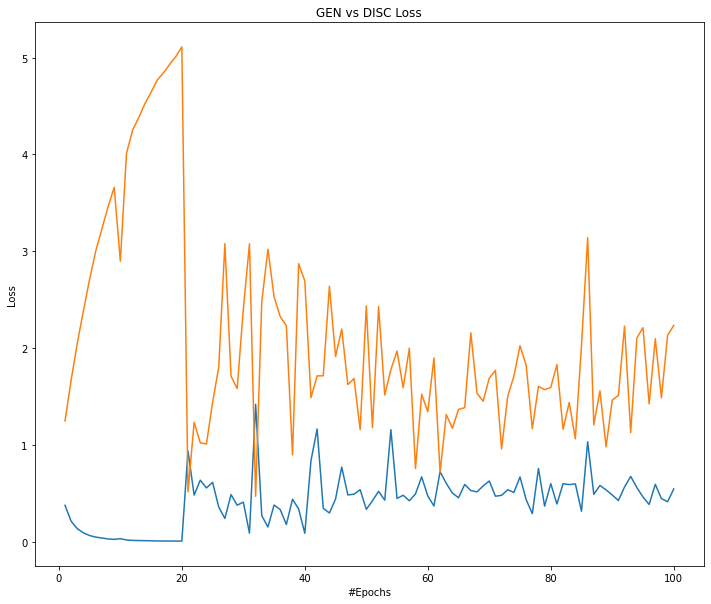

In [22]:
i = list(range(1,NUM_EPOCHS+1))
plt.figure(figsize=(12, 10))
plt.plot(i, [disc_losses[i].cpu().item() for i in range(len(disc_losses))], label='discriminator loss')
plt.plot(i, [gen_losses[i].cpu().item() for i in range(len(gen_losses))], label='generator loss')
plt.xlabel("#Epochs")
plt.ylabel("Loss")
plt.title("GEN vs DISC Loss")
plt.show()